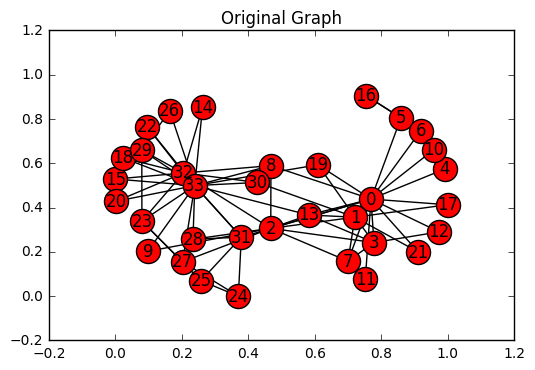

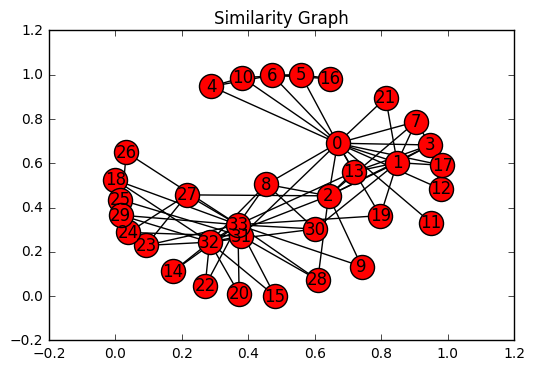

k 2


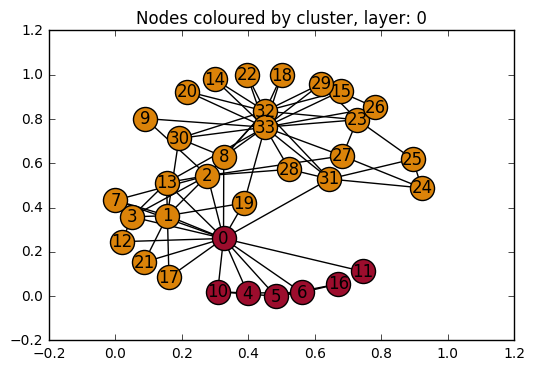

In [15]:
##imports
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy as sp
import som_functions as som

#desired number of nodes in graph
num_nodes = 30

#generate graph
G = generate_graph(num_nodes, 0.1)
#G = nx.davis_southern_women_graph()
G = nx.karate_club_graph()

#draw graph
plt.title('Original Graph')
nx.draw_networkx(G)
plt.show()

#distance matrix -- floyd's algorithms to compute shortest path
dist = nx.floyd_warshall(G)

#similarity graph
H = similarity_graph(G, dist, 1, 0.3)

##number of nodes in H
num_nodes_h = len(H)

#draw similarity graph
plt.title('Similarity Graph')
nx.draw_networkx(H)
plt.show()

##SPECTRAL CLUSTERING BEGINS

#normalised laplacian of G
#identity matrix
I = np.identity(num_nodes_h)

#weight matrix
W = nx.adjacency_matrix(H)

#compute inverse degree matrix
D_inv = np.zeros((num_nodes_h, num_nodes_h))
for i in range(num_nodes_h):
    D_inv[i,i] = 1 / np.sum(W[i,:])
    
#normalised laplacian
L = I - D_inv @ W

#L = nx.laplacian_matrix(H)

#eigenvalues and eigenvectors
val, vec = np.linalg.eigh(L)

##sort eigenvalues (and eigenvectors) into ascending order
idx = val.argsort()

val = val[idx]
vec = vec[:,idx]

## determine k?
k = len(val[val < 1e-12])
k = 2
print('k',k)

##construct matrix U with first k eigenvectors as columns
U = vec[:,:k]

#use k means to assign rows to clusters
clus_ind = k_means(U, k, 1000)

#each list in A corresponds to a different cluster
#A = [[H.nodes()[id] for id,val in enumerate(clus_ind) if val == i] for i in range(k)]
    
#print('clusters',A)

for i in range(len(clus_ind)):
    
    node_name = H.nodes()[i]
    
    G.node[node_name]['cluster0'] = clus_ind[i]

##visualise graph

#randomly generate colours
colours = np.random.rand(k, 3)

#visualise
som.visualise_graph(G, colours, 0)

##save graph to gml file
nx.write_gml(G, "spectralclustering.gml")

In [1]:
##construct similarity graph H using Gaussian similarity measure
def similarity_graph(G, dist, sigma, epsilon):
    
    #list of nodes
    nodes = G.nodes()
    
    #number of nodes
    num_nodes = len(nodes)
    
    #intialise similarity graph
    H = nx.Graph()
    
    for i in range(num_nodes):
        for j in range(i+1,num_nodes):
            
            ##similarity measure
            s = math.exp(-dist[nodes[i]][nodes[j]] ** 2 / (2 * sigma ** 2))
            
            ##check measure is greater than epsilon
            if s > epsilon:
            
                ##add edge to similarity graph
                H.add_edge(nodes[i], nodes[j], weight=s)
            
    ##return similarity graph
    return H

In [7]:
##generate random directed graph with random weights
def generate_graph(num_nodes, p):
    
    #initialise graph
    G = nx.Graph()
    
    G.add_nodes_from(range(num_nodes))
    
    for i in range(num_nodes):
        for j in range(num_nodes):
    
            #add edge with p probablity
            if np.random.rand() < p:
                w = np.random.rand()
                G.add_edge(i, j, weight=w)
    
    #return graph
    return G
    

In [14]:
##k means clustering algorithm
def k_means(U, k, num_iter):
    
    #dimension of data is number of columns
    n, d = U.shape
    
    ##initialise means to random data points
    m = U[np.random.permutation(n)[:k], :]
    
    #cluster indicators
    clus_ind = np.zeros(n, dtype='int')
    
    #distance matrix
    dist = np.zeros((n, k))
    
    ##for each iteration....
    for iter in range(num_iter):
        
        #iterate over data points
        for i in range(n):
            
            #iterate over means
            for j in range(k):
                
                #calculate distance for each data point from mean
                dist[i,j] = np.linalg.norm(U[i,:] - m[j,:]) ** 2
        
            ##assign data point to closest mean
            clus_ind[i] = np.argmin(dist[i,:])
        
        ##recompute means
        #iterate over means
        for j in range(k):
            
            #initialise sum
            sum = np.zeros((1, d))
            
            ##assigned data points
            assigned_points = [da for da in range(n) if clus_ind[da] == j]
            
            #iterate over all datapoints that have been assigned to that mean
            for i in assigned_points:
                
                #add datapoint to sum
                sum += U[i,:]
            
            #update mean
            m[j, :] = sum / len(assigned_points)
            
    ##return means
    return clus_ind.tolist()